<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Наша задача построить модель, которая будет предсказывать количество заказов такси на следующий час, основываясь на исторических данных. Нужно, чтобы начение метрики *RMSE* на тестовой выборке не превышало 48. В том числе, в качестве признаков будут выступать скользящее среднее, отсающие значения и календарные признаки. С помощью подбора оптимальных параметров вышеуказанных значений и настроек моделей попытаемся добиться требуемового значения.


Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.

In [1]:
import pandas as pd

import seaborn as sns
sns.set_theme(style="darkgrid")

from matplotlib import rcParams
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import numpy as np

import math

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

## Подготовка

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('taxi.csv')

In [3]:
display(data.head())
data.shape

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


(26496, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Смотрим, нет ли лишних пробелов

In [4]:
data.loc[0,'datetime']

'2018-03-01 00:00:00'

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [7]:
data.isna().mean()

datetime      0.0
num_orders    0.0
dtype: float64

In [8]:
data['datetime'].duplicated().mean()

0.0

давайте посмотрим, в хронологическом ли порядке у нас дата и время

In [9]:
data['datetime'].is_monotonic 

True

In [6]:
data = data.set_index('datetime')

Из-за того, что нас попросили предсказания на час вперед, для нас подойдет интервал ресемплирования в 1 час

In [7]:
data = data.resample('1H').sum()

### Создание признаков
Работая с временными рядами надо понимать, что колчиество отстающих значений сильно влияет на качество прогноза и количество, нужное для лучшего прогноза сильно зависит от характера данных. тоже самое касается и интервала для скользящего среднего. чтобы не создавать много лишних датафреймов давайте напишем функцию, которая будет возвращать датафрейм уже с готовыми признаками.

In [12]:
data.index.year.unique()

Int64Index([2018], dtype='int64', name='datetime')

In [13]:
print(data.index.month.min(), 'начало периода наблюдений')
print(data.index.month.max(), 'конец периода наблюдений')

3 начало периода наблюдений
8 конец периода наблюдений


In [8]:
def make_features(data, max_lag, rolling_mean_size, week_switch = True, dropp = True, filll = False, monthh = False):
    df =  data.copy()
    if week_switch:
        df['dayofweek'] = df.index.dayofweek
    if monthh:
        df['month'] = df.index.month
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    if filll:
        return df.fillna(-1)
    elif dropp: # это нужно для алгоритмов, основанных на решающих деревьях
        return df.dropna()
    else:
        return df

так как у нас данные, связанные с аэропортом, скорее всего, месяц имеет значение больше, чем, например, день недели. в отличии от городских поездок. Давайте добавим в признаки месяц и день недели и год, и потом, на этапе анализа посмотрим на важность этих признаков и если что-удалим. для этого нам и нужен week_switch. год у нас только 2018

In [15]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [9]:
data_for_plot = make_features(data, 0, 24)

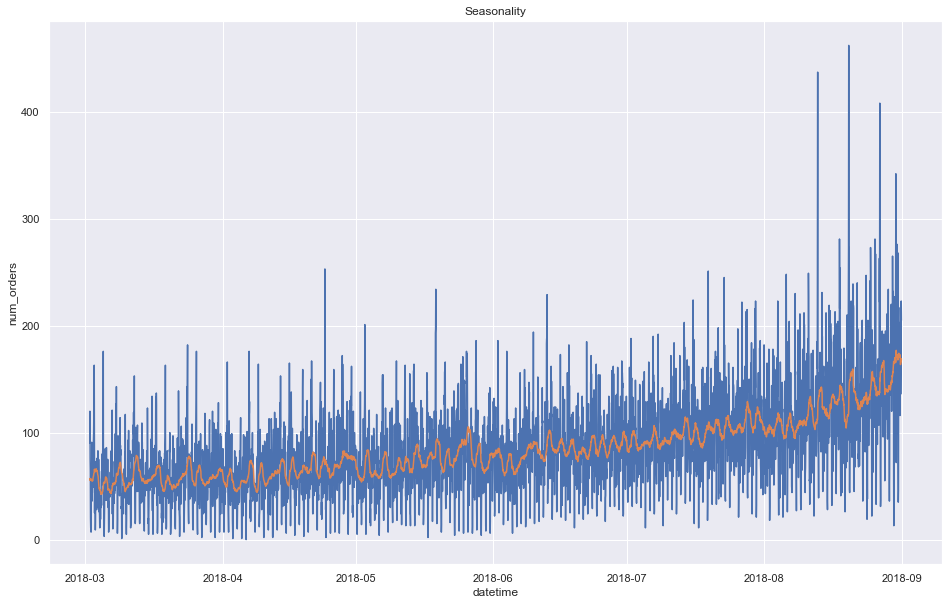

In [12]:
sns.lineplot(x=data_for_plot.index, y='num_orders',data=data_for_plot);
sns.lineplot(x=data_for_plot.index, y='rolling_mean',data=data_for_plot);
rcParams['figure.figsize'] = 16, 9
plt.title('Seasonality');

Как мы можем заметить, до 6 месяца ряд достаточно стационарный, но потом среднее количество заказов ползет вверх. это возможно связано с тем, что в летний период больше перелетов из-за того, что люди улетают в отпуск и соответсвенно больше заказов такси в аэропорт. давайте посмотрим на характеристики временного ряда.

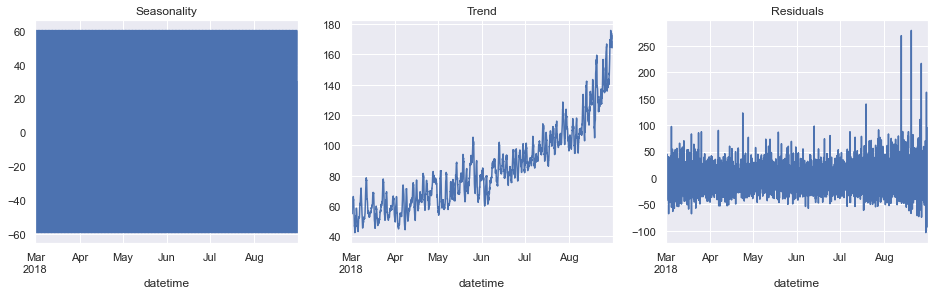

In [13]:
decomposed = seasonal_decompose(data)
fig = plt.figure()
ax1 = fig.add_subplot(2,3,1)
decomposed.seasonal.plot() 
plt.title('Seasonality')
ax2 = fig.add_subplot(2,3,2)
decomposed.trend.plot()
plt.title('Trend')
ax3 = fig.add_subplot(2,3,3)
decomposed.resid.plot() 
plt.title('Residuals')
plt.show()

если с графиком трендов и остатка все более менее понятно, то с графиком, отражающим сезонность все сложнее. это может быть связанно с тем, что у нас слишком короткий период для анализа(5 месяцев). и сезонности по месяцам либо нет, либо она не очевидная и не находится стандартными методами, с учетом того, что это данные о поездках в/из аэропорт/a основной трафик составляют прилетевшие/улетевшие пользователи. потому-что сотрудники  и  персонал даже если двигаются на такси, то плюс минус равномерно в течении года. 

если посмотреть на график тренда, то мы можем заметить значительный рост ровно в июне. что было заметно на изначальном графике. 
в это же время есть скачки помех. возможно, во второй половине августа 2018 произошло какое-то событие, которое заставило людей активнее заказывать такси. это может вызвать проблемы, потому-что в остальном, график шел без выбросов. это может сказаться на качестве  прогнозов. возможно, поможет выбирание более короткого промежутка отстающих значений. неизвестно, надо тестировать. но если пойти по этому пути- то упадет качество прогнозовв на отрезке без выбросов.'

отсутствие явно выраженной сезонности еще один плюс в копилку отбрасывания дня недели. но давайте посмотрим на важность признаков, чтобы в лишний раз убедиться в этом

давайте посмотри на сезонную составляющую данных, ресемплированных сначала по дням(сумма заказов в день) а затем по месяцам

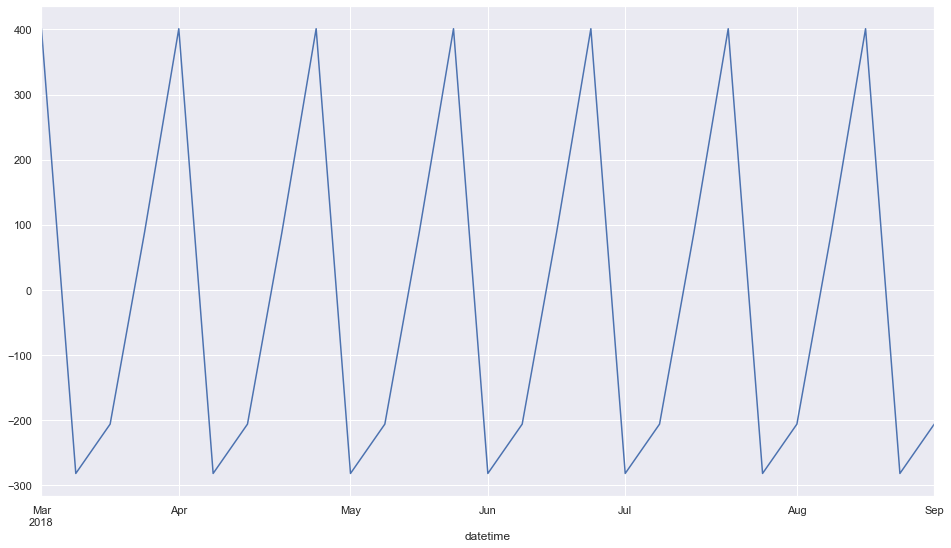

In [14]:
data_for_plot_2 = data.resample('1W').sum()
decomposed2 = seasonal_decompose(data_for_plot_2,  period=4) # в месяце 4 недели, поэтому 4 периода
decomposed2.seasonal.plot();

в зависимости от алгоритма, разные признаки будут иметь разный "вес", но по большому счету, все подчиняется одной закономерности(которую мы и пытаемся изучить и смоделировать) поэтому <strong>одни и те же признаки будут значительными для всех алгоритмов моделей машинного обучения.</strong>

для простоты давайте посмотрим на важность признаков с помощью XGBoost

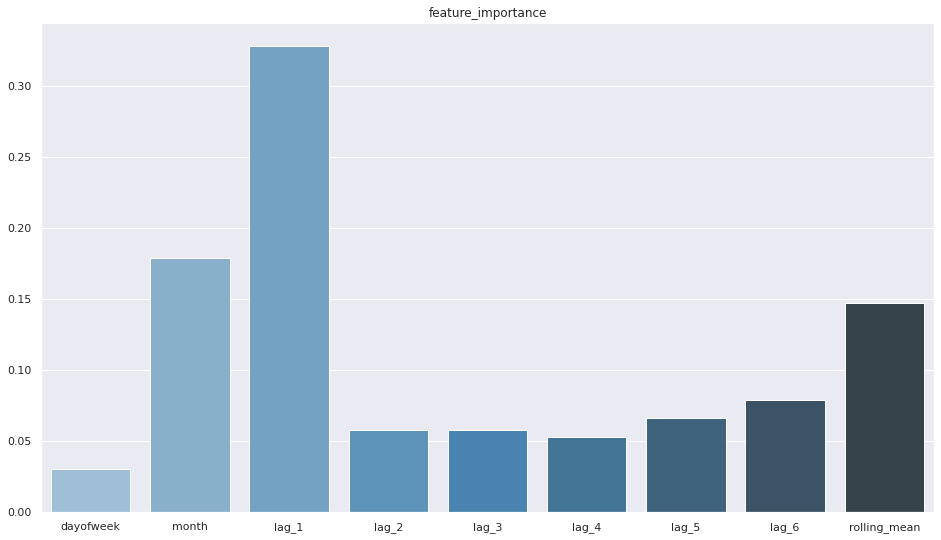

In [20]:
data_imortance = make_features(data, 6, 24) # произвольные парамеетры
feature_importance_train = data_imortance.drop('num_orders', axis = 1) # мы ипользуем все данные, потому-что нам не нужно прове-
target_importance_train = data_imortance['num_orders']#рять качество предсказаний модели
xg_reg_importance = xgb.XGBRegressor()
xg_reg_importance.fit(feature_importance_train, target_importance_train);
sns.barplot(x=feature_importance_train.columns,y=xg_reg_importance.feature_importances_,palette="Blues_d");
plt.title('feature_importance');

нельзя делать выводы о важности признаков только на основе feature_importances_, из-за особенности библиотеки. надо учитывать характер данных. но как было сказанно до этого, скорее всего, день недели может вызвать переобучение модели. если разница между предсказаниями с исппользованием дня недели и не использованием дня недели будут несильно отличаться(в пределах 5) то нужно будет отбросить этот признак, чтобы наша модель гарантированно хорошо себя чвствовала на других данных.

In [21]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


у нас достаточно большое стандартное отклонение. давайте посмотрим на распределение.

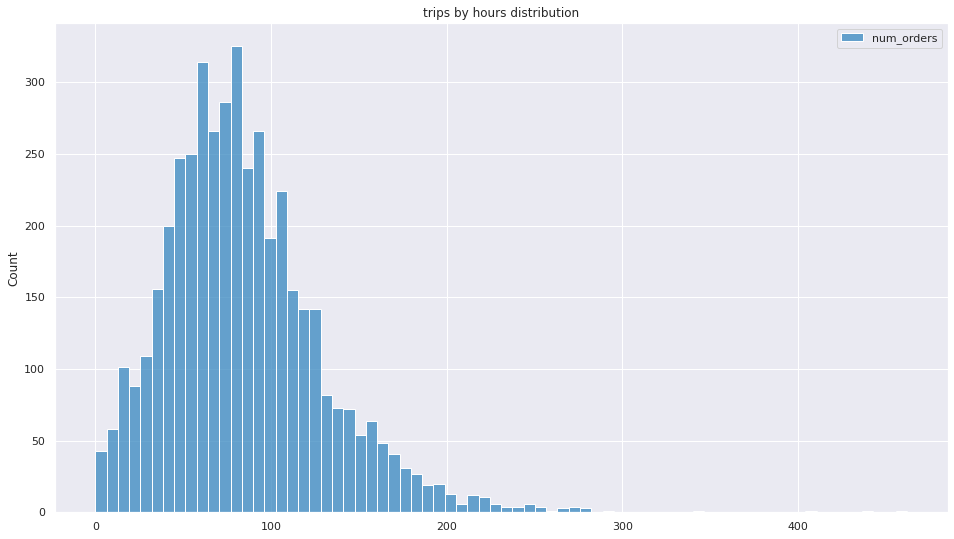

In [22]:
sns.histplot(data=data,palette="Blues_d");
plt.title('trips by hours distribution');

как мы можем заметить, распределение похоже на стандартное, только оно смещеннр вправо. но у нас есть выбросы после 250. давайте посмотрим на эти наблюдения.

In [17]:
data[data['num_orders'] > 250]

,num_orders
datetime,
2018-04-24 00:00:00,253
2018-07-19 10:00:00,251
2018-08-13 01:00:00,273
2018-08-13 02:00:00,437
2018-08-18 00:00:00,281
2018-08-18 02:00:00,254
2018-08-20 01:00:00,272
2018-08-20 02:00:00,462
2018-08-20 04:00:00,273


все они расположены после 13 августа, давайте заполним их средним значением по августу

In [24]:
data[data['num_orders'] > 250]['num_orders'] = data[(data.index.month>7)&
                                                    (data['num_orders'] < 250)]['num_orders'].mean()

/tmp/ipykernel_54/1354269900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['num_orders'] > 250]['num_orders'] = data[(data.index.month>7)&


In [18]:
data = data[(data.index.month<8)|(data.index.day<13)]

## Обучение

### LogisticRegression

основная идея заключается в том, чтобы попарно перебирать все значения отстающих значений и интервала для скользящего среднего для лучшео результата

In [19]:
best_i_logistic = 0
best_j_logistic = 0
rmse_logistic = 0
best_rmse_logistic = 10000000000
for i in range(11):
    for j in range(1,25): # нет смысла делать интервал больше суток.
        ## создаем датасет с нужными признаками
        data_logistic = make_features(data, i, j)
        
        #делим данные на обучающую и тестовую выборки
        train_logistic, test_logistic = train_test_split(data_logistic,shuffle = False, test_size=0.1, train_size = 0.9)

        feature_train_logistic = train_logistic.drop('num_orders', axis = 1)
        target_train_logistic = train_logistic['num_orders']
        
        feature_test_logistic = test_logistic.drop('num_orders', axis = 1)
        target_test_logistic = test_logistic['num_orders']
        # здесь мы будем настраивать только характеристики формата датасета, поэтому здесь не нужна валидационная выборка
        
        #масштабируем данные
        scaler_lin = StandardScaler().fit(feature_train_logistic)
        feature_train_logistic = scaler_lin.transform(feature_train_logistic)
        feature_test_logistic = scaler_lin.transform(feature_test_logistic)
        
        #инициализируем и обучаем модель и делаем предсказания
        model_logistic = LogisticRegression(solver='lbfgs', max_iter=100)
        model_logistic.fit(feature_train_logistic, target_train_logistic)
        predict_logistic = model_logistic.predict(feature_test_logistic)
        
        rmse_logistic = math.sqrt(mean_squared_error(target_test_logistic, predict_logistic))
        if rmse_logistic < best_rmse_logistic:
            best_rmse_logistic = rmse_logistic
            best_j_logistic = j
            best_i_logistic = i
        print('------------')
        print(best_rmse_logistic, ' ', best_i_logistic, ' ', best_j_logistic)
        
print(f'лучшее значение rmse в {best_rmse_logistic} достигается при i = {best_i_logistic} и j = {best_j_logistic}')

------------
46.04795480164283   0   1
------------
46.04795480164283   0   1
------------
46.04795480164283   0   1
------------
46.04795480164283   0   1
------------
46.04795480164283   0   1
------------
46.04795480164283   0   1
------------
45.56339240303259   0   7
------------
45.133416140651846   0   8
------------
45.133416140651846   0   8
------------
45.133416140651846   0   8
------------
45.133416140651846   0   8
------------
45.133416140651846   0   8
------------
45.057347424832116   0   13
------------
44.526538808084425   0   14
------------
44.526538808084425   0   14
------------
44.526538808084425   0   14
------------
44.526538808084425   0   14
------------
44.526538808084425   0   14
------------
44.526538808084425   0   14
------------
44.526538808084425   0   14
------------
44.526538808084425   0   14
------------
44.526538808084425   0   14
------------
44.526538808084425   0   14
------------
44.062052460196135   0   24
------------
44.062052460196135   0

KeyboardInterrupt: 

In [20]:
best_rmse_logistic

41.669444915836216

как я уже сказал ранее, скорее всего, для всех моделей подойдут одни и те же характеристики датасета

### DecisionTreeRegressor

In [27]:
data_tree = make_features(data, 1, 23)#, week_switch = False)

train_tree, temp_tree = train_test_split(data_tree,shuffle = False, train_size=0.8)
valid_tree, test_tree = train_test_split(temp_tree, shuffle = False, test_size=0.5)

feature_train_tree = train_tree.drop('num_orders', axis = 1)
target_train_tree = train_tree['num_orders']

feature_valid_tree = valid_tree.drop('num_orders', axis = 1)
target_valid_tree = valid_tree['num_orders']

feature_test_tree = test_tree.drop('num_orders', axis = 1)
target_test_tree = test_tree['num_orders']

model_tree = DecisionTreeRegressor(random_state = 12345)
model_tree.fit(feature_train_tree, target_train_tree)

model_tree.tree_.max_depth

27

In [ ]:
best_rmse_tree = 10000000000
best_depth_tree = 0
best_i_tree = 0
best_j_tree = 0
for depth in range(1,27):
    for i in range(11):
        for j in range(1,25): # нет смысла делать интервал больше суток.
            for switch in [True, False]:
                data_tree = make_features(data, i, j, week_switch = switch)

                train_tree, temp_tree = train_test_split(data_tree,shuffle = False, train_size=0.8)
                valid_tree, test_tree = train_test_split(temp_tree, shuffle = False, test_size=0.5)

                feature_train_tree = train_tree.drop('num_orders', axis = 1)
                target_train_tree = train_tree['num_orders']

                feature_valid_tree = valid_tree.drop('num_orders', axis = 1)
                target_valid_tree = valid_tree['num_orders']

                feature_test_tree = test_tree.drop('num_orders', axis = 1)
                target_test_tree = test_tree['num_orders']
                # здест нужна тестовая выборка, чтобы при обучении и валидации модель не трогала тестовую выборку
                model_tree = DecisionTreeRegressor(random_state = 12345, max_depth = depth)
                model_tree.fit(feature_train_tree, target_train_tree)
                predict_tree = model_tree.predict(feature_valid_tree)
                rmse_tree = math.sqrt(mean_squared_error(target_valid_tree, predict_tree))
                if rmse_tree < best_rmse_tree:
                    best_rmse_tree = rmse_tree
                    best_depth_tree = depth
                    best_i_tree = i
                    best_j_tree = j
                    best_switch_tree = switch
                print(best_rmse_tree, ' ', best_i_tree, ' ', best_j_tree, ' ', best_depth_tree, ' ', best_switch_tree)
print(f'лучшее значение rmse в {best_rmse_tree} достигается при depth = {best_depth_tree}, i = {best_i_tree},j = {best_j_tree}, switch = {best_switch_tree}')

In [21]:
data_tree = make_features(data, 3, 11, week_switch = False)

train_tree, test_tree = train_test_split(data_tree,shuffle = False, train_size=0.9)

feature_train_tree = train_tree.drop('num_orders', axis = 1)
target_train_tree = train_tree['num_orders']
#чтобы повысить качество модели, мы обучаем модель и на валидационных данных
feature_test_tree = test_tree.drop('num_orders', axis = 1)
target_test_tree = test_tree['num_orders']

model_tree = DecisionTreeRegressor(random_state = 12345, max_depth = 6)
model_tree.fit(feature_train_tree, target_train_tree)
predict_tree = model_tree.predict(feature_test_tree)
rmse_tree = math.sqrt(mean_squared_error(target_test_tree, predict_tree))
rmse_tree

41.26749688145828

### CatBoostRegressor

именно для этого алгоритма мы добавили аргумент dropna для нашей функции трансформации датасета. если в будующем нам приедтся предсказывать данные с пропусками.

In [ ]:
model_cat = CatBoostRegressor(task_type = 'GPU', iterations = 200, random_state = 12345, eval_metric = 'RMSE');
model_cat.fit(feature_train_tree, target_train_tree, eval_set = (feature_test_tree,target_test_tree));

In [ ]:
best_rmse_cat = 10000000000
best_depth_cat = 0
best_i_cat = 0
best_j_cat = 0
for i in range(6): #как показала практика, большое количсевто отстающих значений не дают результата
    for j in range(1,25): # нет смысла делать интервал больше суток.
            data_cat = make_features(data, i, j)

            train_cat, temp_cat = train_test_split(data_cat,shuffle = False, train_size=0.8)
            valid_cat, test_cat = train_test_split(temp_cat, shuffle = False, test_size=0.5)

            feature_train_cat = train_cat.drop('num_orders', axis = 1)
            target_train_cat = train_cat['num_orders']

            feature_valid_cat = valid_cat.drop('num_orders', axis = 1)
            target_valid_cat = valid_cat['num_orders']

            feature_test_cat = test_cat.drop('num_orders', axis = 1)
            target_test_cat = test_cat['num_orders']
            # здест нужна тестовая выборка, чтобы при обучении и валидации модель не трогала тестовую выборку
            model_cat = CatBoostRegressor(task_type = 'GPU', iterations = 200, random_state = 12345, eval_metric = 'RMSE')
            #сильно увеличивать число итераций смысла нет потому-что они все плюс минус находили лучшее решение на 50
            # ни одие поиск не упирался в 200 итерацию
            model_cat.fit(feature_train_cat, target_train_cat, eval_set = (feature_test_cat,target_test_cat))
            predict_cat = model_cat.predict(feature_valid_cat)
            rmse_cat = math.sqrt(mean_squared_error(target_valid_cat, predict_cat))
            if rmse_cat < best_rmse_cat:
                best_rmse_cat = rmse_cat
                best_depth_cat = depth
                best_i_cat = i
                best_j_cat = j
            print(best_rmse_cat, ' ', best_i_cat, ' ', best_j_cat, ' ', best_depth_cat)
print(f'лучшее значение rmse в {best_rmse_cat} достигается при depth = {best_depth_cat}, i = {best_i_cat},j = {best_j_cat}')

In [22]:
data_cat = make_features(data, 5, 24)

train_cat, test_cat = train_test_split(data_cat,shuffle = False, train_size=0.9)

feature_train_cat = train_cat.drop('num_orders', axis = 1)
target_train_cat = train_cat['num_orders']

feature_test_cat = test_cat.drop('num_orders', axis = 1)
target_test_cat = test_cat['num_orders']

model_cat = CatBoostRegressor(task_type = 'GPU', iterations = 400, random_state = 12345, eval_metric = 'RMSE')
model_cat.fit(feature_train_cat, target_train_cat, plot = True, eval_set = (feature_test_cat,target_test_cat))
predict_cat = model_cat.predict(feature_test_cat)
rmse_cat = math.sqrt(mean_squared_error(target_test_cat, predict_cat))
rmse_cat

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.092437
0:	learn: 34.8421523	test: 53.5811863	best: 53.5811863 (0)	total: 8.81ms	remaining: 3.51s
1:	learn: 33.9043665	test: 52.0725650	best: 52.0725650 (1)	total: 14.9ms	remaining: 2.96s
2:	learn: 33.0836124	test: 50.8055040	best: 50.8055040 (2)	total: 23.3ms	remaining: 3.09s
3:	learn: 32.3829855	test: 49.6014445	best: 49.6014445 (3)	total: 30.1ms	remaining: 2.98s
4:	learn: 31.7873502	test: 48.5883824	best: 48.5883824 (4)	total: 36ms	remaining: 2.85s
5:	learn: 31.2385970	test: 47.5981503	best: 47.5981503 (5)	total: 41.8ms	remaining: 2.75s
6:	learn: 30.7522339	test: 46.7600494	best: 46.7600494 (6)	total: 47.7ms	remaining: 2.68s
7:	learn: 30.3261492	test: 45.9077161	best: 45.9077161 (7)	total: 53.7ms	remaining: 2.63s
8:	learn: 29.9500902	test: 45.3622738	best: 45.3622738 (8)	total: 59.2ms	remaining: 2.57s
9:	learn: 29.6387005	test: 44.5909746	best: 44.5909746 (9)	total: 65ms	remaining: 2.54s
10:	learn: 29.3485811	test: 43.9241169	best: 43.9241169 (10)	total: 73.2ms

36.395170831636484

## Вывод
лучшее значение RMSE мы получили используя алгоритм библиотеки CatBoost. именно она нам и подходит

но РМСЕ в 36.4 - это много или мало?
давайте сравним с константной "моделью", которая предскзывает все средним(данные распределены относительно нормально и стандартное отклонение небольшое).

In [27]:
predict_dummy = np.ones(target_test_cat.shape[0])*data['num_orders'].mean()
rmse_dummy = math.sqrt(mean_squared_error(target_test_cat, predict_dummy))
rmse_dummy

53.050835335449285

почти в полтора раза лучше

давайте теперь посмотрим на график наших предсказаний, чтобы увидеть проблемные места

In [50]:
target_test_cat_df 

,num_orders
datetime,
2018-07-27 14:00:00,61
2018-07-27 15:00:00,113
2018-07-27 16:00:00,162
2018-07-27 17:00:00,160
2018-07-27 18:00:00,76
...,...
2018-08-12 19:00:00,82
2018-08-12 20:00:00,98
2018-08-12 21:00:00,135


сначала посмотрим на график "издалека"

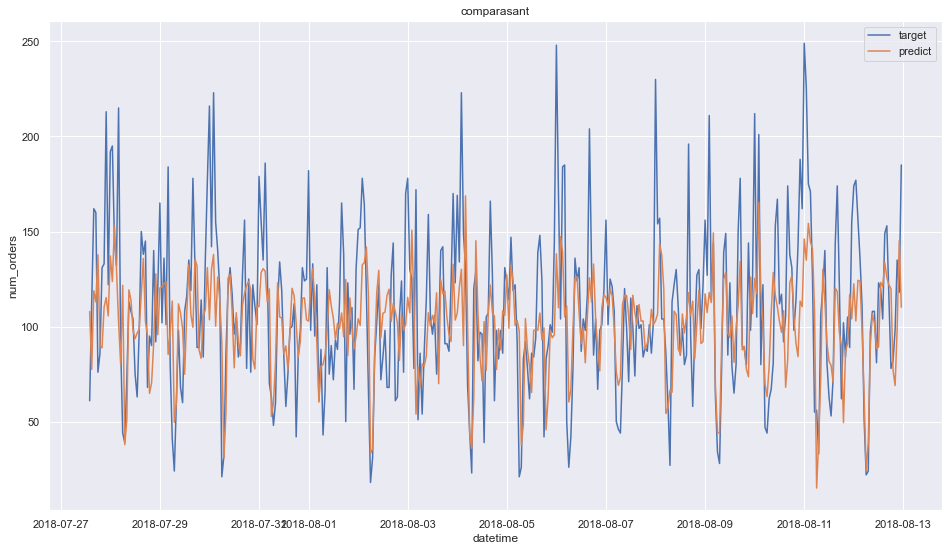

In [59]:
predict_cat_df = pd.DataFrame(data = predict_cat, index = target_test_cat.index, columns = ['num_orders'])
target_test_cat_df = pd.DataFrame(data = target_test_cat, index = target_test_cat.index, columns = ['num_orders'])
ax = sns.lineplot(x=target_test_cat_df.index, y='num_orders',data=target_test_cat_df,legend='brief');
sns.lineplot(x=predict_cat_df.index, y='num_orders',data=predict_cat_df);
rcParams['figure.figsize'] = 16, 9
ax.legend(['target', 'predict'])
plt.title('comparasant');

очевидно, наша модель хорошо предсказывает экстремально низкие значения, справляется средне со значениями, близкими к среднемму и плохо предсказывает экстремаально высокие значения. давайте посмотрим поближе на этот график. выберем интервал, где представлены все выщеуказанные типы значений.

In [65]:
target_test_cat_df[target_test_cat_df['num_orders']>200]

,num_orders
datetime,
2018-07-27 22:00:00,213
2018-07-28 04:00:00,215
2018-07-30 00:00:00,216
2018-07-30 02:00:00,223
2018-08-04 02:00:00,223
2018-08-06 00:00:00,248
2018-08-06 16:00:00,204
2018-08-08 00:00:00,230
2018-08-09 02:00:00,211


In [ ]:
data[(data.index.month<8)|(data.index.day<13)]

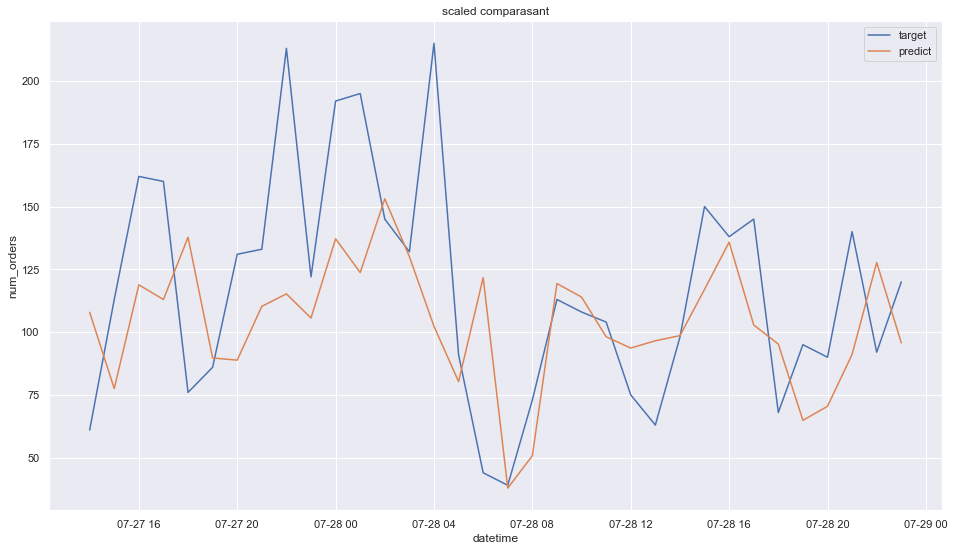

In [72]:
predict_cat_df = pd.DataFrame(data = predict_cat, index = target_test_cat.index, columns = ['num_orders'])
target_test_cat_df = pd.DataFrame(data = target_test_cat, index = target_test_cat.index, columns = ['num_orders'])

predict_cat_df = predict_cat_df[(predict_cat_df.index.month>1)&(predict_cat_df.index.day<29)&(predict_cat_df.index.month == 7)]
target_test_cat_df = target_test_cat_df[(target_test_cat_df.index.month>1)&(target_test_cat_df.index.day<29)&(target_test_cat_df.index.month == 7)]

ax = sns.lineplot(x=target_test_cat_df.index, y='num_orders',data=target_test_cat_df,legend='brief');
sns.lineplot(x=predict_cat_df.index, y='num_orders',data=predict_cat_df);
rcParams['figure.figsize'] = 16, 9
ax.legend(['target', 'predict'])
plt.title('scaled comparasant');

в принципе, кривые похожи, они имеют изгибы примерно в одних и тех же местах.